**Visual Inspection of Motorcycle Connecting Rods
**

Students should develop a software system aimed at visual inspection of motorcycle connecting rods. The system should be able to analyse the dimensions of two different types of connecting rodsto allow a vision-guided robot to pick and sort rods based on their type and dimensions. The two rod types are characterized by a different number of holes: Type A rods have one hole whilst Type B rods have two holes. 


1.   Type of rod (A or B).
2.   Position and orientation (modulo pi)
3.   Length (L), Width (W), Width at the barycenter (WB)
4.   For each hole, position of the centre and diameter size.





While still meeting the requirement of the First Task, students should modify the system in order to deal with one (or more) of the following three changes in the characteristics of the working images:


1.   Images may contain other objects (i.e. screws and washers) that need not to be analysed by the system (such kind of objects are often referred to in computer vision as “distractors”).
2.   Rods can have contact points but do not overlap one to another
3.   The inspection area may be dirty due to the presence of scattered iron powder.



In [1028]:
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
from math import sqrt, atan2, cos, sin, pi,tan, degrees
import math

Load the desired image containing the rods to be analyzed and show it:

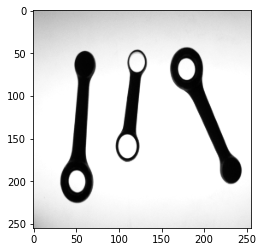

In [1029]:
img = cv2.imread('/content/TESI00.BMP',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='Greys_r')
plt.show()

Perform the binarization of the image through the Otsu algorithm:

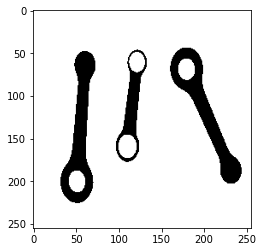

In [1030]:
ret,th = cv2.threshold(img,127,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(th, cmap='Greys_r')
plt.show()

Invert black and white in order to let the function findContours find the proper contours:

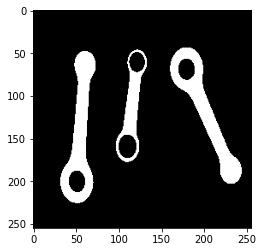

In [1031]:
th = (255-th) 
plt.imshow(th, cmap='Greys_r')
plt.show()

Function used to remove noise.
th: segmented image with noise

In [1032]:
def removeNoise(th):
    th = cv2.medianBlur(th, 3)
    th = cv2.medianBlur(th, 3)
    th = cv2.medianBlur(th, 3)
    th = cv2.medianBlur(th, 3)
    return th

Function used to compute euclidean distance between two points in R2.
p1 and p2: tuple of coordinates of the point (x,y)

In [1033]:
def distance (p1,p2):
    return sqrt((p1[0]-p2[0]) ** 2 + (p1[1]-p2[1]) ** 2)

Function used to find the convex points on a contour.
contour: list of points that belong to a contour (they must be in order)

In [1034]:
def findHotspots(contour): 
    hotspots = []
    pts=contour
    data_pts = np.empty((len(pts), 2), dtype=np.float64)
    for j in range(data_pts.shape[0]):
        data_pts[j,0] = pts[j,0,0]
        data_pts[j,1] = pts[j,0,1]
    k=0
    while (k<data_pts.shape[0]): 
        d = distance(data_pts[k] ,data_pts[(k+4) % data_pts.shape[0]])
        if d<4:
            x,y = data_pts[(k+2) % data_pts.shape[0]]
            hotspots.append([x,y])
            k += 4
        else:
            k += 1
    return hotspots

Function that computes the distance of a point (l) from the line generated by the two points (p1 and p2)

In [1035]:
def distanceLinePoint(p1,p2,l):
    a= 1/(p2[0]-p1[0])
    b= -(1/(p2[1]-p1[1]))
    c= (p1[1]/(p2[1]-p1[1]))- (p1[0]/(p2[0]-p1[0]))
    distance = abs((a*l[0]) + (b*l[1])+c)/(sqrt(a**2+b**2))
    
    return distance

Same function as the one above, but the line is identified from a point (center) and its angular coefficient

In [1036]:
def distanceLinePointAngle(center, m, point):
  a=m
  b=-1
  c=center[1]-(m*center[0])
  distance = abs((a*point[0]) + (b*point[1])+c)/(sqrt(a**2+b**2))
  return distance

The two following functions compute the distance of a point (l) from the line identified by two points (p1 and p2) but the line is traslated of +-0.3

In [1037]:
def distanceLinePointPlus1(p1,p2,l):
    a= 1/(p2[0]-p1[0])
    b= -(1/(p2[1]-p1[1]))
    c= (p1[1]/(p2[1]-p1[1]))- (p1[0]/(p2[0]-p1[0])) + 0.3
    distance = abs((a*l[0]) + (b*l[1])+c)/(sqrt(a**2+b**2))

    return distance

In [1038]:
def distanceLinePointMinus1(p1,p2,l):
    a= 1/(p2[0]-p1[0])
    b= -(1/(p2[1]-p1[1]))
    c= (p1[1]/(p2[1]-p1[1]))- (p1[0]/(p2[0]-p1[0])) - 0.3
    distance = abs((a*l[0]) + (b*l[1])+c)/(sqrt(a**2+b**2))

    return distance

This function sets the 8-neightborhood of a point (p) to background.
It is used on the convex points, because sometimes the line was not enought to separate the two connecting rods connected.

In [1039]:
def delNeight(p,img):
  l= [(p[0],p[1]),(p[0]+1,p[1]),(p[0],p[1]+1),(p[0]-1,p[1]),(p[0],p[1]-1),(p[0]+1,p[1]+1),(p[0]-1,p[1]-1),(p[0]+1,p[1]-1),(p[0]-1,p[1]+1)]
  for i in l:
    img[int(i[1]),int(i[0])]=0

The following function separate the rods connected between each other.
First gets the convex points from the findHotspots() function, then pair them and draw the line of background. A point belong to the line if the distance of that point from the line is below an arbitrary threshold (0.6).

In [1040]:
def separateRods(th, contour):
  hotspots = findHotspots(contour)
  while (len(hotspots)>0):
      first = hotspots.pop(0)
      print(first)
      for i in hotspots:
          hotdistance=[]
          hotdistance.append(distance(first,i))
          print(hotdistance)
      second = hotspots.pop(hotdistance.index(min(hotdistance)))
      toBackground=[]
      for i in range (0,th.shape[0]-1):
          if i>min(first[0],second[0]) and i<max(first[0],second[0]):
              for k in range (0,th.shape[1]-1):
                  if k>min(first[1],second[1]) and k<max(first[1],second[1]):
                      if distanceLinePoint(first, second, (i,k))<0.6:
                          toBackground.append((k,i))
                      if distanceLinePointMinus1(first,second, (i,k))<1 or distanceLinePointPlus1(first,second, (i,k))<1:
                          th[k,i]=255
      for z in toBackground:
          th[z[0],z[1]]=0
  delNeight(first,th)
  delNeight(second,th)

Perform the findcontours() function only on the external contours. These contours will be used to identify the connecting rods that have a contact point and have to be separated.

In [1041]:
contours, hierarchy = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

Remove noise if the image shows it (i.e. in the image are identified more then 10 objects)

In [1042]:
if(len(contours)> 10):
  th= removeNoise(th)
  contours, hierarchy = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

Look for contours much bigger then a normal rod, and try to separate into more rods.

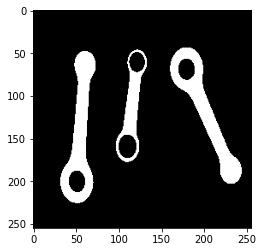

In [1043]:
for i in range(len(contours)):
    area=cv2.contourArea(contours[i])
    if area > 6000:
        separateRods(th,contours[i])
plt.imshow(th, cmap='Greys_r')
plt.show()

Now that we have the image without noise and eventually the connecting rods connected are separated, it's possible to perform the connected components analysis to extract the objects

In [1044]:
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(th, connectivity=4)

Visually show each connected component with a different color

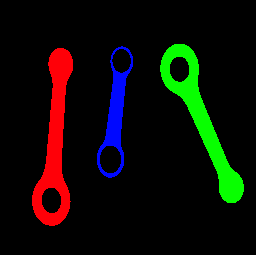

In [1045]:
def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    cv2_imshow(labeled_img)

imshow_components(output)


The getOrientation function takes as input the pts that belong to the same object and return the angle of the major axes computed through the PCA analysis.
Eventually is possible to draw the major and minor axes on the image.

In [1046]:
def getOrientation(pts, img):
    sz = len(pts)
    data_pts = np.empty((sz, 2), dtype=np.float64)
    for i in range(data_pts.shape[0]):
        data_pts[i,0] = pts[i,0,0]
        data_pts[i,1] = pts[i,0,1]
    # Perform PCA analysis
    mean = np.empty((0))
    mean, eigenvectors, eigenvalues = cv2.PCACompute2(data_pts, mean)
    # Store the center of the object
    cntr = (int(mean[0,0]), int(mean[0,1]))
    cv2.circle(img, cntr, 3, (255, 0, 255), 1)
    p1 = (cntr[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + 0.02 *  eigenvectors[0,1] * eigenvalues[0,0])
    p2 = (cntr[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0])
    #draw_axis(img, cntr, p1, (255, 255, 255), 1)
    #draw_axis(img, cntr, p2, (255, 255, 255), 5)
    angle = atan2(eigenvectors[0,1], eigenvectors[0,0]) # orientation in radiants
    label = str(cntr[0])+ ' ' + str(cntr[1])
    labelAngle=  str(round(angle,2)) + ' radiants'
    #cv2.putText(img, text=label , org=(cntr[0], cntr[1]), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.3, color=(255, 255, 255),thickness=1)
    #cv2.putText(img, text=labelAngle , org=(cntr[0], cntr[1]+10), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.3, color=(255, 255, 255),thickness=1)

    return angle

Function used to draw the major and minor axes on the image

In [1047]:
def draw_axis(img, p_, q_, colour, scale):
    p = list(p_)
    q = list(q_)
    angle = atan2(p[1] - q[1], p[0] - q[0]) # angle in radians
    hypotenuse = sqrt((p[1] - q[1]) * (p[1] - q[1]) + (p[0] - q[0]) * (p[0] - q[0]))
    # Here we lengthen the arrow by a factor of scale
    q[0] = p[0] - scale * hypotenuse * cos(angle)
    q[1] = p[1] - scale * hypotenuse * sin(angle)
    cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv2.LINE_AA)
    # create the arrow hooks
    p[0] = q[0] + 9 * cos(angle + pi / 4)
    p[1] = q[1] + 9 * sin(angle + pi / 4)
    cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv2.LINE_AA)
    p[0] = q[0] + 9 * cos(angle - pi / 4)
    p[1] = q[1] + 9 * sin(angle - pi / 4)
    cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv2.LINE_AA)


The following function returns the heigh and the width of the enclosing rectangle of a specific contour (contour). In out case the Height correspond to the lenght of the rod

In [1048]:
def getLenghtWidth(contour):
  rect = cv2.minAreaRect(contour)
  height = int(rect[1][1])
  width = int(rect[1][0])
  if height > width:
    return height, width
  else:
    return width, height

The function getWidthAtBarycenter() as its name says computes the width at barycenter of a rod. 
centroid: barycenter
angle: angle of the major axes in radiants

In cVals are stored all the points that belong to the contour and which their distance to the line that passes from centroid with the given angle is less then an arbitrary threshold (0.9).

Since is not sure that only the two desired points will be stored, it's necessary to distinguish two feasible of them. To do so, is computed the distances of the first point of the cVals list from all the other points in cVals. Then is chosen as width the minimum distance (closest point) but > 2 (i.e. the second point must be on the other side of the rod).

In [1049]:
def getWidthAtBarycenter(centroid, angle, contour):
    cVals = []
    m = tan(angle-math.pi/2)
    yp=centroid[1]
    xp=centroid[0]
    for j in range (0,len(contour)): 
        x,y=contour[j][0]
        value= distanceLinePointAngle(centroid, m, (x,y))
        if value<0.9:
          cVals.append((x,y))
    distances = []
    for i in cVals:
      distances.append(distance(cVals[0],i))
    width = min([k for k in distances if k > 2 ])
    return width

The following function simply print the number of the rod on top of it in the image.

In [1050]:
def putNameOnRod(c,img, number):
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    name = 'Rod ' + str(number)
    cv2.putText(img, text=name , org=(box[2][0], box[2][1]), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.3, color=(0, 0, 0),thickness=1)

The getType() function computes the type of the connecting rod from its hierarchy of contours (h)

In [1051]:
def getType(h):
  firstNested = h[0][0][2]
  if firstNested == -1:
    print('Error! Rod without holes!')
  elif h[0][firstNested][0] == -1:
    return 'A'
  else: 
    return 'B'


Function that computes the barycenter of a contour

In [1052]:
def getContourCenter(c):
  M = cv2.moments(c)
  cx = int(M['m10']/M['m00'])
  cy = int(M['m01']/M['m00'])
  return (cx,cy)

The holeAnalysis() gets as input the contour of a rod, and its hierarchy, and computes for each hole the center and its diameter.

In [1053]:
def holeAnalysis(c, h):
  child = h[0][0][2]
  centers = []
  diameters = []

  countHoles = 0
  while (child != -1):
    holeContour= c[child]
    area = cv2.contourArea(holeContour)
    if area>20:
      contourCenter = getContourCenter(holeContour)
      centers.append(contourCenter)
      diameters.append(distance(contourCenter,c[child][0][0]))
      countHoles += 1
    child = h[0][child][0]
  if countHoles != 1 and countHoles != 2:
    return 0
  else:
    return centers,diameters

In [1054]:
def printInfo(number, angle, width, lenght, aorb, pos, diameters, centerPos, widthAtB):
  print('Rod number '+ str(number) + ' INFO:')
  print('Rod type: ' + aorb)
  x,y = centerPos
  print('Position center of the rod: ', (round(x,2),round(y,2)))
  print('Angle: ' + str(round(angle,2)) + ' degrees')
  print('Lenght: ' + str(round(lenght,2)))
  print('Width: ' + str(round(width,2)))
  print('Width at barycenter: ' + str(round(widthAtB,2)))
  for i in range (len(pos)):
    print('Hole number ' + str(i) + ' is at position ', pos[i] , ' with diameter of ', round(diameters[i],2))
  print('\n')

In [1055]:
def isARod(c, h):
  firstNested = h[0][0][2]
  perimeter = cv2.arcLength(c, True)
  if perimeter == 0:
    return False
  area = cv2.contourArea(c)
  circularity = 4*math.pi*(area/(perimeter*perimeter))
  if firstNested == -1 or area < 1000 or 0.7 < circularity < 1.2:
    return False
  else:
    return True

Now it's extracted each connected component in its own mask, and all the functions defined above are called. At the end the results are shown.

Rod number 1 INFO:
Rod type: A
Position center of the rod:  (201.39, 119.12)
Angle: 67.05 degrees
Lenght: 169
Width: 39
Width at barycenter: 15.23
Hole number 0 is at position  (179, 68)  with diameter of  11.7


Rod number 2 INFO:
Rod type: B
Position center of the rod:  (115.22, 114.18)
Angle: 96.35 degrees
Lenght: 131
Width: 26
Width at barycenter: 13.15
Hole number 0 is at position  (109, 158)  with diameter of  12.65
Hole number 1 is at position  (121, 60)  with diameter of  11.4


Rod number 3 INFO:
Rod type: A
Position center of the rod:  (54.83, 141.36)
Angle: 93.9 degrees
Lenght: 177
Width: 38
Width at barycenter: 14.04
Hole number 0 is at position  (50, 199)  with diameter of  11.4




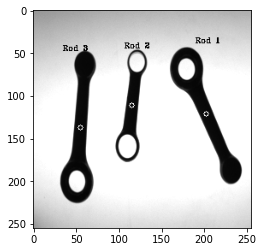

In [1056]:
rodNumber = 1
for label in range(1,nb_components):
  area= stats[label,cv2.CC_STAT_AREA]
  if area>100:
    mask = np.zeros(output.shape, dtype=np.uint8)
    mask[output == label] = 255
    c, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    if isARod(c[0], hierarchy):
      putNameOnRod(c[0],img, rodNumber)
      angle= getOrientation(c[0],img)
      widthAtB = getWidthAtBarycenter(centroids[label], angle, c[0])
      lenght, width= getLenghtWidth(c[0])
      aorb = getType(hierarchy)
      pos, diameters = holeAnalysis(c, hierarchy)
      
      printInfo(rodNumber, degrees(angle) % 180,width,lenght,aorb,pos,diameters, centroids[label], widthAtB)
      rodNumber += 1

plt.imshow(img, cmap='gray')
plt.show()